In [1]:
!pip install tensorflow

In [2]:
# Import
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# from fastai.structured import add_datepart

# Linear Regression
from sklearn.linear_model import LinearRegression

# k-Nearest Neighbors
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Long-term Memory
from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, Activation

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

# Data Collecting

In [3]:
# Config
symbl = 'MSFT'
apiKey = 'MSXSR0YHC991CZN6'

# Fetch Historical Data
df = pd.read_csv('https://www.alphavantage.co/query?datatype=csv&function=TIME_SERIES_MONTHLY&symbol=' + symbl + '&outputsize=compact&apikey=' + apiKey)

# Setting index as date
df['timestamp'] = pd.to_datetime(df.timestamp, format='%Y-%m-%d')
df.index = df['timestamp']

# Data Overview

In [4]:
# Get general statistics
df.describe()

,open,high,low,close,volume
count,256.000000,256.000000,256.000000,256.000000,2.560000e+02
mean,49.753136,53.349432,46.189302,49.653671,9.900380e+08
std,29.927316,33.005746,26.658620,29.682854,4.361976e+08
min,16.035000,18.880000,14.870000,16.150000,2.155232e+08
25%,27.235000,28.215000,25.855000,27.117425,6.457838e+08
50%,36.160000,37.695000,32.740000,36.205000,9.474929e+08
75%,64.358750,69.947500,60.617500,64.320000,1.301201e+09
max,175.440000,180.380000,143.980000,175.000000,3.044579e+09


In [5]:
# Get data types
df.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume                int64
dtype: object

In [6]:
# Check top 10 rows
df.head(10)

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2019-05-14,2019-05-14,130.530,130.650,123.0400,124.73,285095390
2019-04-30,2019-04-30,118.950,131.370,118.1000,130.60,433157868
2019-03-29,2019-03-29,112.890,120.820,108.8000,117.94,589045341
2019-02-28,2019-02-28,103.775,113.240,102.3500,112.03,469095970
2019-01-31,2019-01-31,99.550,107.900,97.2000,104.43,714204787
2018-12-31,2018-12-31,113.000,113.420,93.9600,101.57,944287635
2018-11-30,2018-11-30,107.050,112.240,99.3528,110.89,720228643
2018-10-31,2018-10-31,114.750,116.180,100.1100,106.81,927547942
2018-09-28,2018-09-28,110.850,115.290,107.2300,114.37,480255674


In [7]:
# Check last 10 rows
df.tail(10)

,timestamp,open,high,low,close,volume
timestamp,,,,,,
1998-11-30,1998-11-30,106.37,130.27,104.75,122.00,290676700
1998-10-30,1998-10-30,108.06,110.12,87.75,105.87,410762300
1998-09-30,1998-09-30,95.25,114.62,94.50,110.06,298081100
1998-08-31,1998-08-31,109.12,113.75,95.75,95.94,337509900
1998-07-31,1998-07-31,109.12,119.62,105.37,109.94,307324500
1998-06-30,1998-06-30,83.87,108.56,83.12,108.37,308288100
1998-05-29,1998-05-29,90.19,91.00,81.87,84.81,273845600
1998-04-30,1998-04-30,89.81,99.12,86.62,90.12,254744300
1998-03-31,1998-03-31,85.87,90.94,79.25,89.50,274981900


## Prepare data to merge with sentimental analysis

In [8]:
cropped_df = df[(df['timestamp'].dt.year >= 2000)]

In [9]:
cropped_df.tail(10)

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2000-10-31,2000-10-31,60.50,70.12,48.44,68.87,1234707800
2000-09-29,2000-09-29,70.00,72.06,58.63,60.31,712766900
2000-08-31,2000-08-31,69.94,74.87,68.12,69.81,609699900
2000-07-31,2000-07-31,79.69,82.87,67.25,69.81,617092900
2000-06-30,2000-06-30,64.37,82.19,63.81,80.00,733525100
2000-05-31,2000-05-31,72.87,74.00,60.38,62.56,672215400
2000-04-28,2000-04-28,94.44,96.50,65.00,69.75,1129073300
2000-03-31,2000-03-31,89.62,115.00,88.94,106.25,1014093800
2000-02-29,2000-02-29,98.50,110.00,88.12,89.37,667243800


In [10]:
cropped_df = cropped_df.reset_index(drop=True)
# Drop last row
cropped_df = cropped_df[:-1]

In [11]:
cropped_df.tail(5)

,timestamp,open,high,low,close,volume
227,2000-06-30,64.37,82.19,63.81,80.00,733525100
228,2000-05-31,72.87,74.00,60.38,62.56,672215400
229,2000-04-28,94.44,96.50,65.00,69.75,1129073300
230,2000-03-31,89.62,115.00,88.94,106.25,1014093800
231,2000-02-29,98.50,110.00,88.12,89.37,667243800


In [12]:
news_data = pd.read_csv("data/sentimental_data.csv")

In [13]:
news_data.head(10)

,year,month,positive
0,2000,1,0.541624
1,2000,2,0.537205
2,2000,3,0.537788
3,2000,4,0.536477
4,2000,5,0.541516
5,2000,6,0.532644
6,2000,7,0.537956
7,2000,8,0.539437
8,2000,9,0.535648
9,2000,10,0.534441


In [14]:
news_data.tail(10)

,year,month,positive
223,2018,8,0.565977
224,2018,9,0.553506
225,2018,10,0.548968
226,2018,11,0.552921
227,2018,12,0.561755
228,2019,1,0.548660
229,2019,2,0.556610
230,2019,3,0.562695
231,2019,4,0.544137
232,2019,5,0.543147


In [15]:
news_data = news_data[::-1].reset_index().drop(columns=['index'])

In [16]:
news_data.head(10)

,year,month,positive
0,2019,5,0.543147
1,2019,4,0.544137
2,2019,3,0.562695
3,2019,2,0.556610
4,2019,1,0.548660
5,2018,12,0.561755
6,2018,11,0.552921
7,2018,10,0.548968
8,2018,9,0.553506
9,2018,8,0.565977


In [17]:
#Drop first row
news_data = news_data[1:]

In [18]:
news_data = news_data.reset_index()

In [19]:
# Combine two datasets
sentimental_df = pd.concat([cropped_df, news_data], axis=1, join_axes=[cropped_df.index])

In [20]:
sentimental_df.head(5)

,timestamp,open,high,low,close,volume,index,year,month,positive
0,2019-05-14,130.530,130.65,123.04,124.73,285095390,1,2019,4,0.544137
1,2019-04-30,118.950,131.37,118.10,130.60,433157868,2,2019,3,0.562695
2,2019-03-29,112.890,120.82,108.80,117.94,589045341,3,2019,2,0.556610
3,2019-02-28,103.775,113.24,102.35,112.03,469095970,4,2019,1,0.548660
4,2019-01-31,99.550,107.90,97.20,104.43,714204787,5,2018,12,0.561755


In [21]:
news_data2 = pd.read_csv("data/sentimental_data2.csv")
#Drop first row
news_data2 = news_data2[1:]
sentimental_df = pd.concat([cropped_df, news_data2], axis=1, join_axes=[cropped_df.index])

## Add SMA

In [22]:
symbl = 'MSFT'
apiKey = 'MSXSR0YHC991CZN6'

# Fetch SMA Data
sma = pd.read_csv('https://www.alphavantage.co/query?function=SMA&symbol=' + symbl + '&interval=monthly&time_period=10&series_type=open&apikey=' + apiKey + '&datatype=csv')


In [23]:
sma.head(10)

,time,SMA
0,2019-05-14,111.7375
1,2019-04-30,108.4945
2,2019-03-29,106.5275
3,2019-02-28,104.5595
4,2019-01-31,103.2290
5,2018-12-31,102.6730
6,2018-11-30,100.8520
7,2018-10-31,98.7595
8,2018-09-28,95.6445
9,2018-08-31,92.9275


In [24]:
# Drop the first row and reset index
sma = sma[1:].reset_index()

In [25]:
sma_df = pd.concat([sentimental_df, sma], axis=1, join_axes=[sentimental_df.index])
sma_df.head(10)

,timestamp,open,high,low,close,volume,year,month,appearance,positive2,index,time,SMA
0,2019-05-14,130.530,130.650,123.0400,124.73,285095390,NaN,NaN,NaN,NaN,1,2019-04-30,108.4945
1,2019-04-30,118.950,131.370,118.1000,130.60,433157868,2000.0,2.0,7.0,0.428571,2,2019-03-29,106.5275
2,2019-03-29,112.890,120.820,108.8000,117.94,589045341,2000.0,3.0,11.0,0.500000,3,2019-02-28,104.5595
3,2019-02-28,103.775,113.240,102.3500,112.03,469095970,2000.0,4.0,46.0,0.489130,4,2019-01-31,103.2290
4,2019-01-31,99.550,107.900,97.2000,104.43,714204787,2000.0,5.0,34.0,0.602941,5,2018-12-31,102.6730
5,2018-12-31,113.000,113.420,93.9600,101.57,944287635,2000.0,6.0,44.0,0.500000,6,2018-11-30,100.8520
6,2018-11-30,107.050,112.240,99.3528,110.89,720228643,2000.0,7.0,10.0,0.550000,7,2018-10-31,98.7595
7,2018-10-31,114.750,116.180,100.1100,106.81,927547942,2000.0,8.0,7.0,0.714286,8,2018-09-28,95.6445
8,2018-09-28,110.850,115.290,107.2300,114.37,480255674,2000.0,9.0,12.0,0.416667,9,2018-08-31,92.9275
9,2018-08-31,106.030,112.777,104.8400,112.33,456630721,2000.0,10.0,14.0,0.535714,10,2018-07-31,89.7955


In [26]:
sma_df = sma_df.drop(columns = ['open','high','low','year','month','time'])

## Add STOCH indicator

In [27]:
symbl = 'MSFT'
apiKey = 'MSXSR0YHC991CZN6'

# Fetch SMA Data
stoch = pd.read_csv('https://www.alphavantage.co/query?function=STOCH&symbol=' + symbl + '&interval=monthly&time_period=10&series_type=open&apikey=' + apiKey + '&datatype=csv')


In [28]:
# Drop the first row and reset index
stoch = stoch[1:].reset_index()

In [29]:
all_data = pd.concat([sma_df, stoch], axis=1, join_axes=[sma_df.index])
all_data.head(5)

,timestamp,close,volume,appearance,positive2,index,SMA,index,time,SlowD,SlowK
0,2019-05-14,124.73,285095390,NaN,NaN,1,108.4945,1,2019-04-30,72.1060,89.5142
1,2019-04-30,130.60,433157868,7.0,0.428571,2,106.5275,2,2019-03-29,59.1869,72.5735
2,2019-03-29,117.94,589045341,11.0,0.500000,3,104.5595,3,2019-02-28,52.2875,54.2304
3,2019-02-28,112.03,469095970,46.0,0.489130,4,103.2290,4,2019-01-31,58.3607,50.7567
4,2019-01-31,104.43,714204787,34.0,0.602941,5,102.6730,5,2018-12-31,68.6283,51.8754


In [30]:
# Drop abundant timestamp and index columns
all_data = all_data.drop(columns = ['index','time'])

## Find correlation

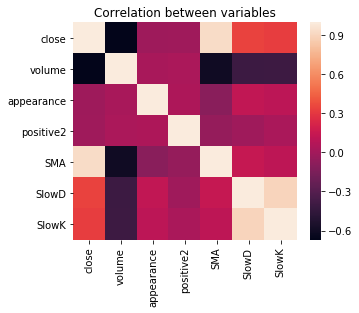

In [31]:
corr = all_data.corr()
f, ax = plt.subplots(figsize=(5, 4))
plt.title("Correlation between variables")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)